In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 1 Preprocessing 
## 1.1 Merging 
We first combine data of all cities. We add a binary variable "weekdays", which indicate if the price data is collected during week day or weekend.

In [2]:
cities = ['amsterdam', 'athens', 'barcelona', 'berlin', 'budapest', 'lisbon', 
          'london', 'paris', 'rome', 'vienna']
days = ['weekdays', 'weekends']

k = 0

for city in cities:
    for day in days:
        file_name = './Data_to_use/archive/' + city + '_' + day + '.csv'
        data = pd.read_csv(file_name)
        data = data.drop(data.columns[0], axis=1)
        data['city'] = city
        if (day == 'weekdays'):
            data['weekdays'] = 1;
        else:
            data['weekdays'] = 0;
        if k == 0:
            all_cities = data
            k = 1
        else:
            all_cities = pd.concat([all_cities, data])
all_cities.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,weekdays
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,amsterdam,1
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,amsterdam,1
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,amsterdam,1
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,...,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,amsterdam,1
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,...,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,amsterdam,1


In [3]:
#all_cities.to_csv("all_cities_data.csv")
all_cities["room_type"].unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

## 1.2. Encoding Categorical Features
### 1.2.1 Split data into train and test set, stratified over "city". Identify columns that need to be encoded by different methods, columns that needs to be dropped, and columns that are to be copied from original data X into preprocessed data X without processing.




In [4]:
print(list(all_cities.columns))
features = list(all_cities.columns);
binary_encoding_features = ["room_shared", "room_shared", "host_is_superhost"]
ordinal_encoding_features = ["room_type"];
hashing_encoding_features = ["city"]

['realSum', 'room_type', 'room_shared', 'room_private', 'person_capacity', 'host_is_superhost', 'multi', 'biz', 'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist', 'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index', 'rest_index_norm', 'lng', 'lat', 'city', 'weekdays']


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelBinarizer
X = all_cities.drop(["lng", "lat", "attr_index_norm", "rest_index_norm", "realSum"], axis = 1);
y = all_cities["realSum"];

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, stratify = all_cities["city"])
for cities_name in cities:
    dev_num = X_dev[X_dev["city"] == cities_name].shape[0];
    test_num = X_test[X_test["city"] == cities_name].shape[0];
    assert (np.abs((dev_num / test_num) - 4) < 0.05);
X_dev_preprocessed = pd.DataFrame();
X_test_preprocessed = pd.DataFrame();

In [6]:
onehot_encoding_feature = ["room_type"];
binary_ordinal_encoding_feature = ["room_shared", "room_private", "host_is_superhost"];
target_encoding_feature = ["city"];
dropped_feature = ["lng", "lat", "attr_index_norm", "rest_index_norm"];
target_feature = ["realSum"];
numerical_feature = ["cleanliness_rating", 'guest_satisfaction_overall',
                    'dist', 'metro_dist',
                    'attr_index', 'rest_index']
modified_feature = [onehot_encoding_feature, 
                    binary_ordinal_encoding_feature, 
                    target_encoding_feature,
                    dropped_feature,
                    target_feature,
                    numerical_feature];

non_modified_feature = list(all_cities.columns);
for lists in modified_feature:
    for features in lists:
        print(features)
        non_modified_feature.remove(features);
print(non_modified_feature)



room_type
room_shared
room_private
host_is_superhost
city
lng
lat
attr_index_norm
rest_index_norm
realSum
cleanliness_rating
guest_satisfaction_overall
dist
metro_dist
attr_index
rest_index
['person_capacity', 'multi', 'biz', 'bedrooms', 'weekdays']


### 1.2.2 Encoding "room_type" with one hot encoding since "room_type" does not have high cardinality and involves no order.

In [7]:
for features in onehot_encoding_feature:
    features_ohe_dev = pd.get_dummies(X_dev[features])
    features_ohe_test = pd.get_dummies(X_test[features])
    for columns in features_ohe_dev.columns:
        X_dev_preprocessed[columns] = features_ohe_dev[columns];
        X_test_preprocessed[columns] = features_ohe_test[columns];


### 1.2.3 Encoding "room_shared", "room_private", and "host_is_superhost" with ordinal binary encoding since those are binary categorical variable.


In [8]:
for features in binary_ordinal_encoding_feature:
    ordinal_encoder = LabelBinarizer();
    X_dev_preprocessed[features] = ordinal_encoder.fit_transform(
        X_dev[features].to_numpy().reshape(-1, 1));
    X_test_preprocessed[features] = ordinal_encoder.transform(
        X_test[features].to_numpy().reshape(-1, 1))
X_dev_preprocessed.head()

,Entire home/apt,Private room,Shared room,room_shared,room_private,host_is_superhost
4199,1,0,0,0,0,0
95,0,1,0,0,1,0
975,1,0,0,0,0,0
517,0,1,0,0,1,0
1486,1,0,0,0,0,0


### 1.2.4 Encoding "city" with target encoding. "city" is a column with high cardinality, therefore, using ordinal encoding will predispose the model to having biased estimation of effect of city with high or low index, and using one-hot encoding will introduce high sparsity, making preprocessing more difficult. 

In [9]:
from category_encoders.target_encoder import TargetEncoder

for features in target_encoding_feature:
    target_encoder = TargetEncoder(cols = [features]).fit(X_dev[features], y_dev);
    X_dev_preprocessed[features + "_te"] = target_encoder.transform(X_dev[features]);
    X_test_preprocessed[features + "_te"] = target_encoder.transform(X_test[features]);
    X_dev_preprocessed[features] = X_dev[features]
    X_test_preprocessed[features] = X_test[features]

In [10]:
X_dev_preprocessed.head()
X_dev.head()

,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,rest_index,city,weekdays
4199,Entire home/apt,False,False,2.0,False,1,0,10.0,93.0,1,4.920695,1.826950,234.262550,638.129773,rome,1
95,Private room,False,True,2.0,False,0,1,8.0,90.0,1,3.250577,0.431475,131.375077,162.042941,berlin,1
975,Entire home/apt,False,False,5.0,False,0,1,10.0,95.0,2,2.162390,0.442592,658.430044,1580.448990,rome,0
517,Private room,False,True,2.0,False,1,0,8.0,79.0,1,1.897402,0.377272,309.928497,715.358716,barcelona,0
1486,Entire home/apt,False,False,4.0,False,0,0,9.0,90.0,1,3.023732,0.233334,256.177058,639.212414,paris,1


### 1.2.5 Will talk to my teammate about what to do with numerical feature, should we standardize them or not. I will do it here anyway.

In [11]:
for features in numerical_feature:
    standard_scaler = StandardScaler().fit(X_dev[features].to_numpy().reshape(-1, 1));
    X_dev_preprocessed[features] = standard_scaler.transform(X_dev[features].to_numpy().reshape(-1, 1));
    X_test_preprocessed[features] = standard_scaler.transform(X_test[features].to_numpy().reshape(-1, 1));
X_dev_preprocessed.head()

,Entire home/apt,Private room,Shared room,room_shared,room_private,host_is_superhost,city_te,city,cleanliness_rating,guest_satisfaction_overall,dist,metro_dist,attr_index,rest_index
4199,1,0,0,0,0,0,205.099142,rome,0.638999,0.040512,0.715360,1.326609,-0.263291,0.029144
95,0,1,0,0,1,0,239.278151,berlin,-1.459793,-0.295743,0.019819,-0.292901,-0.724289,-0.934044
975,1,0,0,0,0,0,205.099142,rome,0.638999,0.264682,-0.433370,-0.279999,1.637237,1.935584
517,0,1,0,0,1,0,291.899646,barcelona,-1.459793,-1.528680,-0.543727,-0.355806,0.075738,0.185389
1486,1,0,0,0,0,0,396.057458,paris,-0.410397,-0.295743,-0.074654,-0.522853,-0.165101,0.031334


### 1.2.6 Copy data features that have not been modified into preprocessed data frame.

In [12]:
for features in non_modified_feature:
    X_dev_preprocessed[features] = X_dev[features]
    X_test_preprocessed[features] = X_test[features]
X_dev_preprocessed.head() 

,Entire home/apt,Private room,Shared room,room_shared,room_private,host_is_superhost,city_te,city,cleanliness_rating,guest_satisfaction_overall,dist,metro_dist,attr_index,rest_index,person_capacity,multi,biz,bedrooms,weekdays
4199,1,0,0,0,0,0,205.099142,rome,0.638999,0.040512,0.715360,1.326609,-0.263291,0.029144,2.0,1,0,1,1
95,0,1,0,0,1,0,239.278151,berlin,-1.459793,-0.295743,0.019819,-0.292901,-0.724289,-0.934044,2.0,0,1,1,1
975,1,0,0,0,0,0,205.099142,rome,0.638999,0.264682,-0.433370,-0.279999,1.637237,1.935584,5.0,0,1,2,0
517,0,1,0,0,1,0,291.899646,barcelona,-1.459793,-1.528680,-0.543727,-0.355806,0.075738,0.185389,2.0,1,0,1,0
1486,1,0,0,0,0,0,396.057458,paris,-0.410397,-0.295743,-0.074654,-0.522853,-0.165101,0.031334,4.0,0,0,1,1


## 1.3 Filtering
### 1.3.1 Filtering price outliers. From EDV, the team observed that hotels having price above 3000 Euro are rare cases and therefore should be considered outlier in train dataset.

In [13]:
threshold = 2500
X_dev_preprocessed["realSum"] = y_dev

indexPrice = X_dev_preprocessed[X_dev_preprocessed['realSum'] >= threshold].index

X_dev_preprocessed.drop(indexPrice , inplace=True)
y_dev.drop(indexPrice, inplace=True)

assert(X_dev_preprocessed.shape[0] == y_dev.shape[0])
X_dev_preprocessed = X_dev_preprocessed.drop(["realSum"], axis = 1)

### 1.3.2 Search for highly correlated column pairs (|corr| >= 0.9)and drop one of them. 

In [14]:
X_dev_preprocessed.loc[:, X_dev_preprocessed.columns != 'city'].var(ddof=0)

Entire home/apt                   0.232916
Private room                      0.230948
Shared room                       0.007271
room_shared                       0.007271
room_private                      0.230948
host_is_superhost                 0.190178
city_te                       10393.166463
cleanliness_rating                1.000486
guest_satisfaction_overall        1.001178
dist                              1.003129
metro_dist                        1.003937
attr_index                        0.998150
rest_index                        0.999394
person_capacity                   1.686139
multi                             0.207333
biz                               0.227085
bedrooms                          0.393361
weekdays                          0.249945
dtype: float64

[('Entire home/apt', 'Private room'), ('Entire home/apt', 'room_private'), ('Private room', 'room_private'), ('Shared room', 'room_shared')]


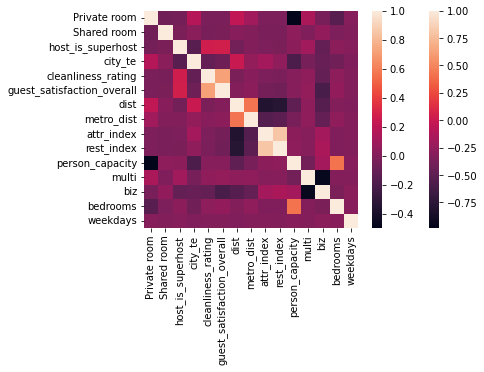

In [15]:
corrM = X_dev_preprocessed.select_dtypes(include=np.number).corr()
sns.heatmap(corrM)
num_features = X_dev_preprocessed.select_dtypes(include=np.number).columns;
high_corr_pair = []
for feature1 in num_features:
    for feature2 in num_features:
        if (np.abs(corrM[feature1][feature2]) >= 0.9
            and (feature2, feature1) not in high_corr_pair
            and feature1 != feature2):
            high_corr_pair.append((feature1, feature2))
print(high_corr_pair)
X_dev_preprocessed = X_dev_preprocessed.drop(['Entire home/apt', 'room_private', 'room_shared'], axis = 1);
X_test_preprocessed = X_test_preprocessed.drop(['Entire home/apt', 'room_private', 'room_shared'], axis = 1);
corrM = X_dev_preprocessed.select_dtypes(include=np.number).corr()
sns.heatmap(corrM)
num_features = X_dev_preprocessed.select_dtypes(include=np.number).columns;


## 1.4. Missing value handling.
### 1.4.1 There is no missing value in the data so no processing regarding missing value is necessaery.

In [16]:
print(f'Number of missing value in original dataset for each feature is \n {all_cities.isnull().sum()}')
print(f'No processing required')

Number of missing value in original dataset for each feature is 
 realSum                       0
room_type                     0
room_shared                   0
room_private                  0
person_capacity               0
host_is_superhost             0
multi                         0
biz                           0
cleanliness_rating            0
guest_satisfaction_overall    0
bedrooms                      0
dist                          0
metro_dist                    0
attr_index                    0
attr_index_norm               0
rest_index                    0
rest_index_norm               0
lng                           0
lat                           0
city                          0
weekdays                      0
dtype: int64
No processing required


## 1.5. Imbalance Data
The imbalanced data on target class is not an issue in regression problems. Imbalance in categorical variables such as “cleanliness rating” and “person_capacity” would not severely undermine the performance of regressor. Therefore no work in necessary to handle features with imbalanced data in the dataset. 

## 1.6. Sparse Data.
The team will perform feature selection based on feature sparsity.
### 1.6.1 Visualize sparsity.

Text(0.5, 0, '% of 0 entries')

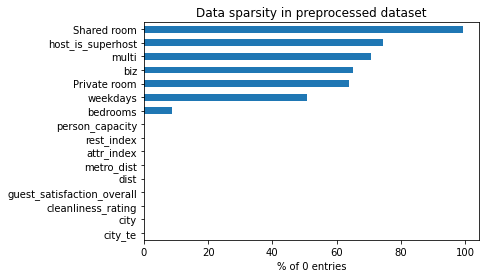

In [17]:
sparsity = pd.Series((X_dev_preprocessed.shape[0] - np.count_nonzero(X_dev_preprocessed, axis = 0)) * 100 / X_dev_preprocessed.shape[0],
                    index = X_dev_preprocessed.columns).sort_values(ascending = True)
ax = sparsity.plot.barh(title = "Data sparsity in preprocessed dataset");
ax.set_xlabel("% of 0 entries")

In [18]:
sparsity_threshold = 0.8;
for features in X_dev_preprocessed.columns:
    sparsity = (X_dev_preprocessed.shape[0] - 
                np.count_nonzero(X_dev_preprocessed[features], axis = 0)) / X_dev_preprocessed.shape[0]
    
    if (sparsity > sparsity_threshold):
        print(features)
        print(sparsity)
        X_dev_preprocessed = X_dev_preprocessed.drop([features], axis = 1)
        X_test_preprocessed = X_test_preprocessed.drop([features], axis = 1)
                
X_dev_preprocessed.head()
    
    
    

Shared room
0.9926750731263673


,Private room,host_is_superhost,city_te,city,cleanliness_rating,guest_satisfaction_overall,dist,metro_dist,attr_index,rest_index,person_capacity,multi,biz,bedrooms,weekdays
4199,0,0,205.099142,rome,0.638999,0.040512,0.715360,1.326609,-0.263291,0.029144,2.0,1,0,1,1
95,1,0,239.278151,berlin,-1.459793,-0.295743,0.019819,-0.292901,-0.724289,-0.934044,2.0,0,1,1,1
975,0,0,205.099142,rome,0.638999,0.264682,-0.433370,-0.279999,1.637237,1.935584,5.0,0,1,2,0
517,1,0,291.899646,barcelona,-1.459793,-1.528680,-0.543727,-0.355806,0.075738,0.185389,2.0,1,0,1,0
1486,0,0,396.057458,paris,-0.410397,-0.295743,-0.074654,-0.522853,-0.165101,0.031334,4.0,0,0,1,1


# 2 Model training
## 2.1 Fit linear regression to predict hotel price in individual cities

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression

individual_city_regressor_dict = {};

parameters_FlexNet = {'alpha':[0.05,0.5, 1], 'l1_ratio':[ 0.5, 0.75, 0.95], 'max_iter':[100, 500, 1000]}

for individual_cities in cities:
    indexCity_dev = X_dev_preprocessed[X_dev_preprocessed['city'] == individual_cities].index;
    data_X_city = X_dev_preprocessed.iloc[indexCity_dev];
    data_X_city = data_X_city.drop(['city', 'city_te'], axis = 1)
    data_y_city = y_dev.iloc[indexCity_dev];
    clf_EleNet_city = GridSearchCV(estimator = ElasticNet() , 
                                   param_grid = parameters_FlexNet, 
                                   cv = 5,
                                   refit=True
                                  )
    clf_EleNet_city.fit(data_X_city, np.log(data_y_city))
    #individual_city_regressor_dict[individual_cities] = LinearRegression().fit(data_X_city, data_y_city);
    individual_city_regressor_dict[individual_cities] = clf_EleNet_city.best_estimator_
    
    print(clf_EleNet_city.best_params_)



{'alpha': 0.05, 'l1_ratio': 0.5, 'max_iter': 100}
{'alpha': 0.05, 'l1_ratio': 0.5, 'max_iter': 100}
{'alpha': 0.05, 'l1_ratio': 0.5, 'max_iter': 100}
{'alpha': 0.05, 'l1_ratio': 0.5, 'max_iter': 100}
{'alpha': 0.05, 'l1_ratio': 0.5, 'max_iter': 100}
{'alpha': 0.05, 'l1_ratio': 0.5, 'max_iter': 100}
{'alpha': 0.05, 'l1_ratio': 0.5, 'max_iter': 100}
{'alpha': 0.05, 'l1_ratio': 0.5, 'max_iter': 100}
{'alpha': 0.05, 'l1_ratio': 0.5, 'max_iter': 100}
{'alpha': 0.05, 'l1_ratio': 0.5, 'max_iter': 100}


## 2.2 Fit Adaboost regressor to the entire dataset. 

In [20]:
from sklearn.ensemble import AdaBoostRegressor

parameters_Adaboost = {'n_estimators':[5,10,15, 20], 
                       'learning_rate':[0.2, 0.25, 0.3, 0.35, 0.4], 
                       'loss':['linear']}

clf_Adaboost = GridSearchCV(estimator = AdaBoostRegressor(), 
                               param_grid = parameters_Adaboost, 
                               cv = 5,
                               refit=True
                              )
%time clf_Adaboost.fit(X_dev_preprocessed.drop(['city'], axis = 1), np.log(y_dev))

CPU times: user 1min 11s, sys: 399 ms, total: 1min 11s
Wall time: 1min 11s


GridSearchCV(cv=5, estimator=AdaBoostRegressor(),
             param_grid={'learning_rate': [0.2, 0.25, 0.3, 0.35, 0.4],
                         'loss': ['linear'], 'n_estimators': [5, 10, 15, 20]})

In [21]:
best_Adaboost_tree = clf_Adaboost.best_estimator_;
print(clf_Adaboost.best_params_)

{'learning_rate': 0.35, 'loss': 'linear', 'n_estimators': 15}


# 3 Model Evaluation
## 3.1 Evaluate Elasticnet regressor for each city

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
for (cities, estimators) in individual_city_regressor_dict.items(): 
    indexCity_test = X_test_preprocessed[X_test_preprocessed['city'] == cities].index;
    data_X_city_test = X_test_preprocessed.iloc[indexCity_test];
    data_X_city_test = data_X_city_test.drop(['city', 'city_te'], axis = 1);

    data_y_city_test = np.log(y_test.iloc[indexCity_test]);
    y_pred = estimators.predict(data_X_city_test);
    print(f'Elasticnet regressor for city {cities} has the following scores:')
    print(f'R^2:', estimators.score(data_X_city_test, data_y_city_test));
    print(f'MSE', mean_squared_error(data_y_city_test, y_pred));
    print(f'MAE', mean_absolute_error(data_y_city_test, y_pred));
    print(f'MAPE', mean_absolute_percentage_error(data_y_city_test, y_pred));

Elasticnet regressor for city amsterdam has the following scores:
R^2: 0.16224424793713577
MSE 0.28422599538297955
MAE 0.41286763269379034
MAPE 0.0768578502860756
Elasticnet regressor for city athens has the following scores:
R^2: 0.24165131014095287
MSE 0.27902311974823935
MAE 0.41546821855855465
MAPE 0.07596081256347775
Elasticnet regressor for city barcelona has the following scores:
R^2: 0.24660473776318392
MSE 0.2509079097650856
MAE 0.40032009730406337
MAPE 0.0761817864486011
Elasticnet regressor for city berlin has the following scores:
R^2: 0.1989942337237226
MSE 0.2870224075991241
MAE 0.4025854884944996
MAPE 0.07299475592931666
Elasticnet regressor for city budapest has the following scores:
R^2: 0.22593342743852074
MSE 0.30760669233972593
MAE 0.4263691293904794
MAPE 0.07799567228469174
Elasticnet regressor for city lisbon has the following scores:
R^2: 0.22522771513408402
MSE 0.28110107468118734
MAE 0.42055002158151505
MAPE 0.07719552796316367
Elasticnet regressor for city lon

In [23]:
data_X_city_test = X_test_preprocessed.drop(['city'], axis = 1);

data_y_city_test = np.log(y_test);
y_pred = best_Adaboost_tree.predict(data_X_city_test);
print(f'Adaboost Regressor for entire dataset has the following scores:')
print(f'R^2:', best_Adaboost_tree.score(data_X_city_test, data_y_city_test));
print(f'MSE', mean_squared_error(data_y_city_test, y_pred));
print(f'MAE', mean_absolute_error(data_y_city_test, y_pred));
print(f'MAPE', mean_absolute_percentage_error(data_y_city_test, y_pred));

Adaboost Regressor for entire dataset has the following scores:
R^2: 0.5333641551438408
MSE 0.1645527383765328
MAE 0.31170723071699474
MAPE 0.058181121720359386


# 4 Model Interpretation

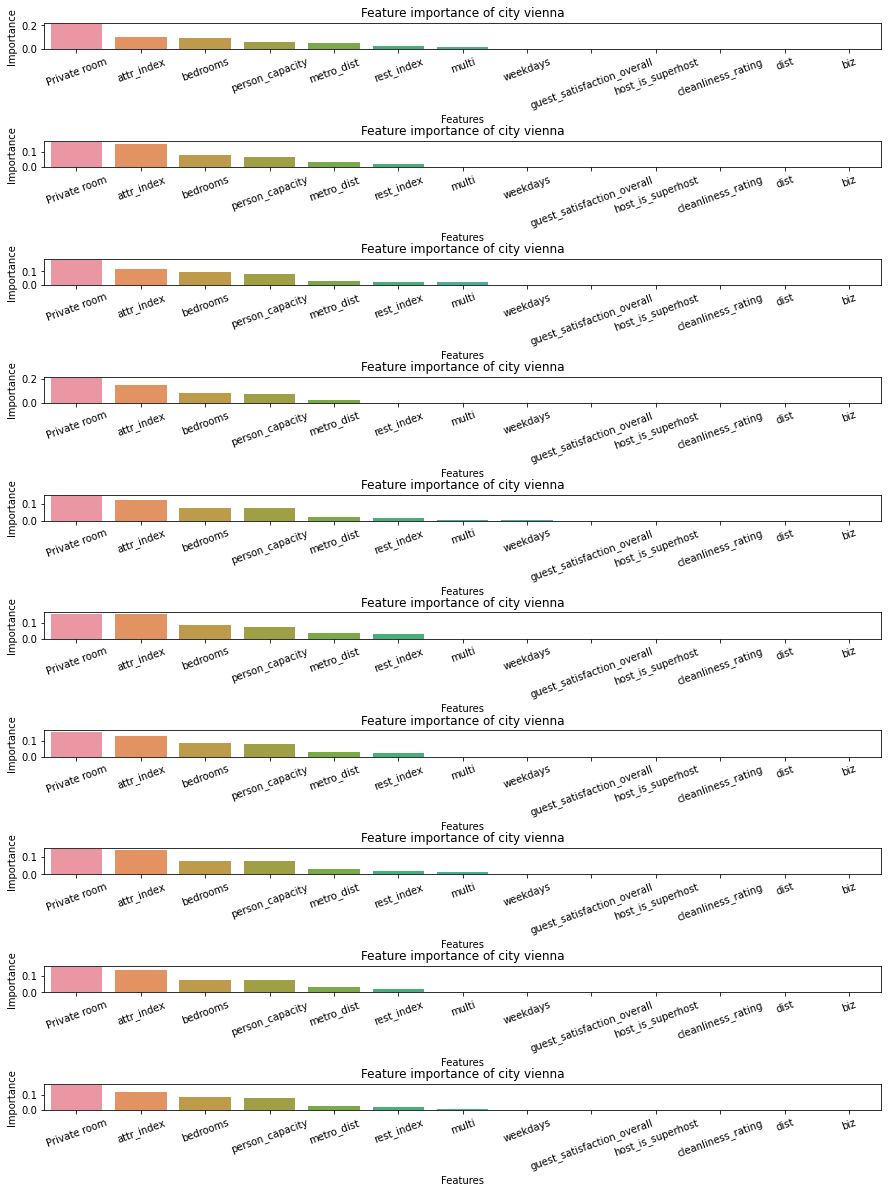

In [24]:
fig, axes = plt.subplots(10, 1, figsize=(15,20))
fig.subplots_adjust(hspace=3.5, wspace= 0.1)

counter = 0;
feature_column = X_dev_preprocessed.drop(['city', 'city_te'], axis = 1).columns;
for (cities, estimators) in individual_city_regressor_dict.items():   
    coefficients = estimators.coef_;
    df = pd.DataFrame(list(zip(feature_column, np.abs(coefficients))),
                      columns=['Features', "Importance"])

  
    sns.barplot(data=df, x="Features", y="Importance", 
                ax = axes[counter],
                order=df.sort_values('Importance',ascending = False).Features
               ).set_title("Feature importance of city " + individual_cities)
    axes[counter].set_xticklabels(axes[0].get_xticklabels(), rotation=20)

    
    counter = counter + 1;
    


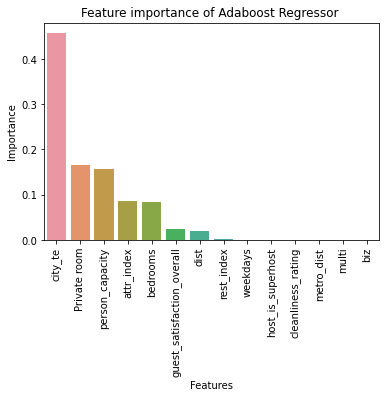

In [35]:
#fig, axes = plt.subplots(1, 1, figsize=(15,20))

feature_importance_adaboost = best_Adaboost_tree.feature_importances_
features_adaboost = X_test_preprocessed.drop(['city'], axis = 1).columns

df = pd.DataFrame(list(zip(features_adaboost, np.abs(feature_importance_adaboost ))),
                      columns=['Features', "Importance"])

bar_plot = sns.barplot(data=df, x="Features", y="Importance", 
                order=df.sort_values('Importance',ascending = False).Features
               ).set_title("Feature importance of Adaboost Regressor ")
plt.xticks(rotation=90)
plt.show()